# Distortion Classification

In [1]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [2]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_parameter"
LOG_DIR = "_log/" + EXPERIMENT_NAME

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 252 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


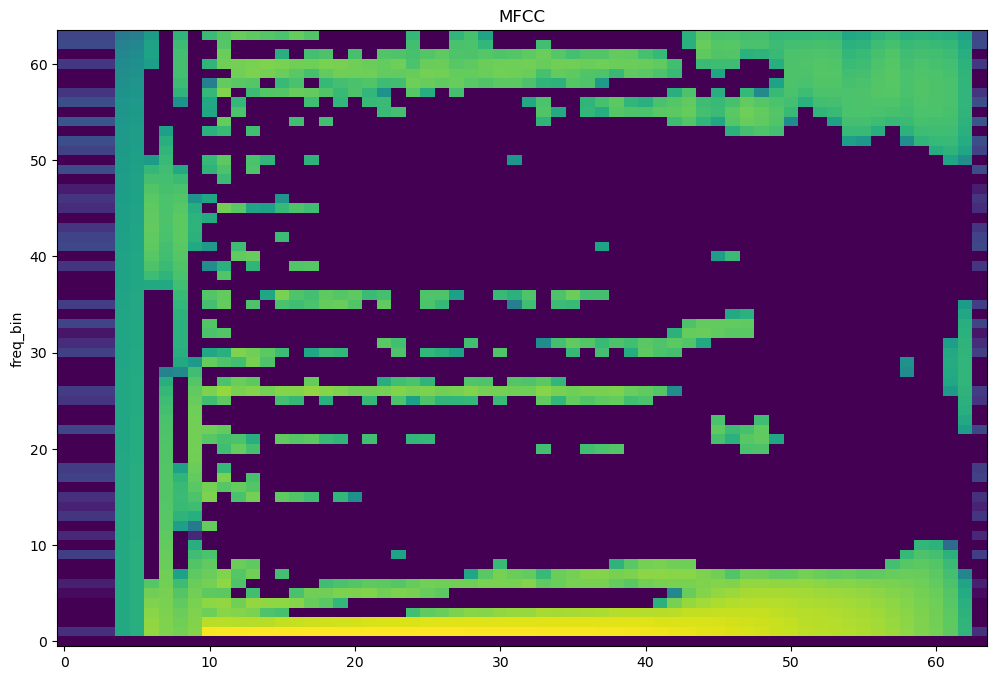

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-SINGLE/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]
EFFECT = 4

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        effect=EFFECT_MAP[EFFECT])

signal, _, _, _, _ = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [4]:
from src.extrector import train

BATCH_SIZE = round(len(fxData) / 200)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [5]:
from src.extrector import model
from torch import nn

LEARNING_RATE = 0.001
EPOCHS = 10

# construct model and assign it to device
cnn = model.Extractor().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS,
            effect=EFFECT)


Epoch 1
loss: 0.200801  [  0/202]
loss: 0.248957  [ 20/202]
loss: 0.044027  [ 40/202]
loss: 0.020304  [ 60/202]
loss: 0.009618  [ 80/202]
loss: 0.012893  [100/202]
loss: 0.009339  [120/202]
loss: 0.003245  [140/202]
loss: 0.005060  [160/202]
loss: 0.035739  [180/202]
loss: 0.004987  [200/202]
reverb: avg MSE: 0.017801, avg abs error: 0.11
learning rate: 0.001000 -> 0.000910
---------------------------

Epoch 2
loss: 0.020937  [  0/202]
loss: 0.024536  [ 20/202]
loss: 0.008240  [ 40/202]
loss: 0.005308  [ 60/202]
loss: 0.003104  [ 80/202]
loss: 0.020138  [100/202]
loss: 0.120797  [120/202]
loss: 0.006708  [140/202]
loss: 0.046798  [160/202]
loss: 0.015383  [180/202]
loss: 0.019059  [200/202]
reverb: avg MSE: 0.014468, avg abs error: 0.1
learning rate: 0.000910 -> 0.000820
---------------------------

Epoch 3
loss: 0.005458  [  0/202]
loss: 0.012347  [ 20/202]
loss: 0.002273  [ 40/202]
loss: 0.000739  [ 60/202]
loss: 0.002597  [ 80/202]
loss: 0.000478  [100/202]
loss: 0.049661  [120/202]

#### Save model weight and bias

In [6]:
WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + "_" + str(EFFECT) + ".pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Trained feed forward net saved at _weights/c53_parameter_4.pth


#### Evaluation

reverb: avg MSE: 0.132637, avg abs error: 0.31
reverb: avg MSE: 0.381186, avg abs error: 0.57
reverb: avg MSE: 0.381188, avg abs error: 0.57
reverb: avg MSE: 0.172408, avg abs error: 0.38
reverb: avg MSE: 0.004274, avg abs error: 0.05


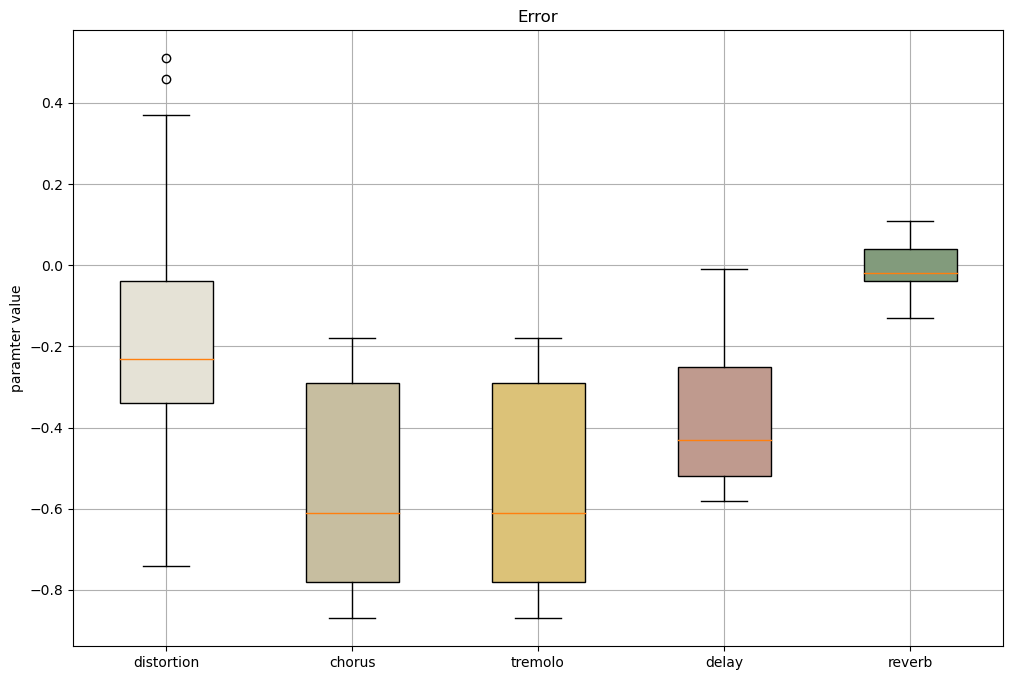

In [7]:
from src.util import plot_box

cnn = model.Extractor().to(device)

error = [[], [], [], [], []]
for i in range(5):
    WEIGHTS_FILE = WEIGHTS_FILE[:-5] + str(i) + ".pth"
    state_dict = torch.load(WEIGHTS_FILE)
    cnn.load_state_dict(state_dict)

    _, _, log = train.test(cnn, val_dataloader, device, effect=EFFECT)
    for _, data in enumerate(log):
        error[i].append(data[3])

log_writer.add_figure("Error Box", 
                      plot_box(error, title="Error", labels=EFFECT_MAP, ylabel="paramter value"))

log_writer.close()